In [1]:
from keras.utils import normalize
import numpy as np
from matplotlib import pyplot as plt
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import sys
import time

from tensorflow import keras
import segmentation_models as sm
from tensorflow.keras.metrics import MeanIoU

Segmentation Models: using `tf.keras` framework.


In [2]:
'''Load data'''
sys.path.extend(['..'])
from data.adv_data_generator import ImageLoader

file = ["train"]
type_mod = ["img","mask","aug"]
dataset_aug = [[],[],[]]
num = 0
for i in file:
    for j in type_mod:
        loader = ImageLoader(i, j)
        dataset_aug[num] = loader.loadAug()
        num += 1

file = ["test","val"]
type_ori = ["images","masks"]
dataset = [[],[],[],[]]
num = 0
for i in file:
    for j in type_ori:
        loader = ImageLoader(i, j)
        dataset[num] = loader.loadData()
        num += 1

In [3]:
'''Define dataset'''
train_img = dataset_aug[0]
train_mask = dataset_aug[1]
train_aug = dataset_aug[2]

test_img = dataset[0]
test_mask = dataset[1]
val_img = dataset[2]
val_mask = dataset[3]

In [44]:
def getPercentage(data):
    # Get unique values and their counts
    unique_values, counts = np.unique(data, return_counts=True)
    
    # Calculate total number of elements
    total_elements = len(data)*64*64
    
    # Calculate percentages
    percentages = (counts / total_elements) * 100
    
    # Print the results
    for value, percentage in zip(unique_values, percentages):
        print(f"Value {value} appears {percentage:.8f}% of the time.")

def getCount(data):
    # Get unique values and their counts
    unique_values, counts = np.unique(data, return_counts=True)
    
    # Print the results
    for value, count in zip(unique_values, counts):
        print(f"Value {value} appears {count} of the time.")

In [4]:
import random

'''
(1) Set the seed
(2) Generate a random permutation of indices
(3) Use the same random indices for sampling both arrays
'''

def sampling(img, mask, seed, percentage=0.2):
    sample_size = int(len(img) * percentage)
    random.seed(seed)
    random_indices = random.sample(range(len(img)), sample_size)
    sample_img = img[random_indices]
    sample_mask = mask[random_indices]

    return sample_img, sample_mask

sam_val_img, sam_val_mask = sampling(val_img, val_mask, 4)
sam_test_img, sam_test_mask = sampling(test_img, test_mask, 7)

print(sam_val_mask.shape)
print(sam_test_mask.shape)
print(np.unique(sam_test_mask))

(6415, 64, 64)
(6415, 64, 64)
[0 1 2 3 4 5 6 7]


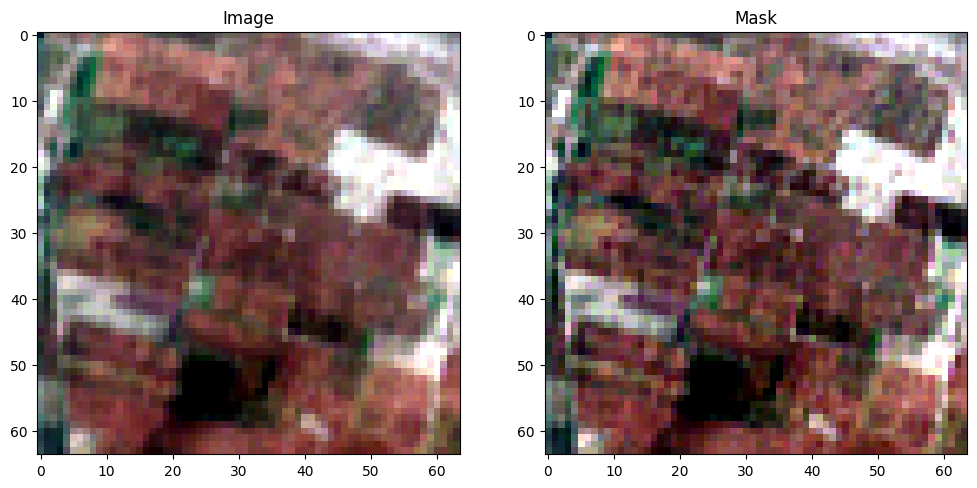

In [32]:
plt.figure(figsize=(12, 8))
plt.subplot(121)
plt.imshow(train_img[1])
plt.title('Image')
plt.subplot(122)
plt.imshow(train_aug[1])
plt.title('Mask')
plt.show()

In [8]:
# #Encode labels... but multi dim array so need to flatten, encode and reshape
# from sklearn.preprocessing import LabelEncoder
# labelencoder = LabelEncoder()
# train_masks_reshaped = train_mask.reshape(-1,1)
# train_masks_reshaped = train_masks_reshaped.ravel()
# train_masks_reshaped_encoded = labelencoder.fit_transform(train_masks_reshaped)
# train_masks_reshaped_encoded.shape

In [9]:
# from sklearn.utils.class_weight import compute_class_weight

# class_weights = compute_class_weight('balanced',classes=np.unique(train_masks_reshaped_encoded), y = train_masks_reshaped_encoded)
# class_weights = dict(enumerate(class_weights))
# class_weights

In [5]:
'''Define variable to run the model'''
X = np.concatenate((train_img, train_aug), axis=0)
y = np.concatenate((train_mask, train_mask), axis=0)
# X = train_img
# y = train_mask
X_val = sam_val_img
y_val = sam_val_mask

In [6]:
n_classes = 8
from keras.utils import to_categorical
y_cat = to_categorical(y, num_classes=n_classes)
y_val_cat = to_categorical(y_val, num_classes=n_classes)

In [7]:
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda, Activation

In [8]:
import tensorflow as tf
from keras import backend as K
from keras.layers import Layer

class MaxPoolingWithArgmax2D(Layer):

    def __init__(
            self,
            pool_size=(2, 2),
            strides=(2, 2),
            padding='same',
            **kwargs):
        super(MaxPoolingWithArgmax2D, self).__init__(**kwargs)
        self.padding = padding
        self.pool_size = pool_size
        self.strides = strides

    def call(self, inputs, **kwargs):
#         print("max pooling with argmax")
        padding = self.padding
        pool_size = self.pool_size
        strides = self.strides
        if K.backend() == 'tensorflow':
            ksize = [1, pool_size[0], pool_size[1], 1]
            padding = padding.upper()
            strides = [1, strides[0], strides[1], 1]
            output, argmax = tf.nn.max_pool_with_argmax(
                    inputs,
                    ksize=ksize,
                    strides=strides,
                    padding=padding)
        else:
            errmsg = '{} backend is not supported for layer {}'.format(
                    K.backend(), type(self).__name__)
            raise NotImplementedError(errmsg)
        argmax = tf.cast(argmax, K.floatx())
        return [output, argmax]
    
    def compute_output_shape(self, input_shape):
#         print("i guess its subsampling")
        ratio = (1, 2, 2, 1)
        output_shape = [
                dim//ratio[idx]
                if dim is not None else None
                for idx, dim in enumerate(input_shape)]
        output_shape = tuple(output_shape)
        return [output_shape, output_shape]

In [9]:
class MaxUnpooling2D(Layer):
    def __init__(self, size=(2, 2), **kwargs):
        super(MaxUnpooling2D, self).__init__(**kwargs)
        self.size = size

    def call(self, inputs, output_shape=None):
        # one is pool and one is mask
        updates, mask = inputs[0], inputs[1]

        mask = tf.cast(mask, 'int32')
        input_shape = tf.shape(updates, out_type='int32')

        #  calculation new shape
        if output_shape is None:
            output_shape = (
                input_shape[0],
                input_shape[1]*self.size[0],
                input_shape[2]*self.size[1],
                input_shape[3])
        self.output_shape1 = output_shape

        # calculation indices for batch, height, width and feature maps
        one_like_mask = tf.ones_like(mask, dtype='int32')      #creates ones of the same shape as the mask
        batch_shape = tf.concat([[input_shape[0]], [1], [1], [1]], axis=0)
        batch_range = tf.reshape(tf.range(output_shape[0], dtype='int32'),shape=batch_shape)
        b = one_like_mask * batch_range

        y = mask // (output_shape[2] * output_shape[3])

        x = (mask // output_shape[3]) % output_shape[2]

        feature_range = tf.range(output_shape[3], dtype='int32')

        f = one_like_mask * feature_range

        # transpose indices & reshape update values to one dimension
        updates_size = tf.size(updates)       # Prints the number of elements in the updates
        indices = tf.transpose(tf.reshape(tf.stack([b, y, x, f]), [4, updates_size]))
        values = tf.reshape(updates, [updates_size])
        ret = tf.scatter_nd(indices, values, output_shape)
        return ret

    def compute_output_shape(self, input_shape):
        mask_shape = input_shape[1]
        return (
                mask_shape[0],
                mask_shape[1]*self.size[0],
                mask_shape[2]*self.size[1],
                mask_shape[3]
                )

In [10]:
def usegnet_model_base(n_classes, IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, pool_size=(2, 2)):

    # encoder 
    
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS)) 
    
    conv_1 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv1")(inputs) 
    conv_1 = BatchNormalization()(conv_1) 
    conv_1 = Activation("relu")(conv_1) 
    conv_2 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal', name="block1_conv2")(conv_1) 
    conv_2 = BatchNormalization()(conv_2) 
    conv_2 = Activation("relu")(conv_2)
    
    pool_1, mask_1 = MaxPoolingWithArgmax2D(pool_size, name="block1_pool")(conv_2)
    
    conv_3 = Conv2D(128, (3, 3), padding="same" , kernel_initializer='he_normal', name="block2_conv1")(pool_1)
    conv_3 = BatchNormalization()(conv_3)
    conv_3 = Activation("relu")(conv_3)
    conv_4 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal',  name="block2_conv2")(conv_3)
    conv_4 = BatchNormalization()(conv_4)
    conv_4 = Activation("relu")(conv_4)
    
    pool_2, mask_2 = MaxPoolingWithArgmax2D(pool_size, name="block2_pool")(conv_4)
    
    conv_5 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv1")(pool_2)
    conv_5 = BatchNormalization()(conv_5)
    conv_5 = Activation("relu")(conv_5)
    conv_6 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv2")(conv_5)
    conv_6 = BatchNormalization()(conv_6)
    conv_6 = Activation("relu")(conv_6)
    conv_7 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal', name="block3_conv3")(conv_6)
    conv_7 = BatchNormalization()(conv_7)
    conv_7 = Activation("relu")(conv_7)
    
    pool_3, mask_3 = MaxPoolingWithArgmax2D(pool_size, name="block3_pool")(conv_7)
    
    #bottleneck
    conv_11 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal', name="block5_conv1")(pool_3)
    conv_11 = BatchNormalization()(conv_11)
    conv_11 = Activation("relu")(conv_11)
    conv_12 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv2")(conv_11)
    conv_12 = BatchNormalization()(conv_12)
    conv_12 = Activation("relu")(conv_12)
    conv_13 = Conv2D(256, (3, 3), padding="same" , kernel_initializer='he_normal',  name="block5_conv3")(conv_12)
    conv_13 = BatchNormalization()(conv_13)
    conv_13 = Activation("relu")(conv_13)
       
    #decoder
    unpool_1 = MaxUnpooling2D(pool_size)([conv_13, mask_3])
    
    conv_14 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_1)
    conv_14 = BatchNormalization()(conv_14)
    conv_14 = Activation("relu")(conv_14)
    conv_15 = Conv2D(256, (3, 3), padding="same", kernel_initializer='he_normal')(conv_14)
    conv_15 = BatchNormalization()(conv_15)
    conv_15 = Activation("relu")(conv_15)
    conv_16 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(conv_15)
    conv_16 = BatchNormalization()(conv_16)
    conv_16 = Activation("relu")(conv_16)
    
    unpool_2 = MaxUnpooling2D(pool_size)([conv_16, mask_2])
    
    conv_17 = Conv2D(128, (3, 3), padding="same", kernel_initializer='he_normal')(unpool_2)
    conv_17 = BatchNormalization()(conv_17)
    conv_17 = Activation("relu")(conv_17)
    conv_18 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_17)
    conv_18 = BatchNormalization()(conv_18)
    conv_18 = Activation("relu")(conv_18)
    
    unpool_3 = MaxUnpooling2D(pool_size)([conv_18, mask_1])
    
    #concatenation (unpool_4, conv_2)
    merge = concatenate([unpool_3,conv_2], axis = -1)
    
    conv_19 = Conv2D(64, (1, 1), padding="same", kernel_initializer='he_normal')(merge)
    conv_19 = BatchNormalization()(conv_19)
    conv_19 = Activation("relu")(conv_19)
    
    conv_20 = Conv2D(64, (3, 3), padding="same", kernel_initializer='he_normal')(conv_19)
    conv_20 = BatchNormalization()(conv_20)
    conv_20 = Activation("relu")(conv_20)
    
    conv_21 = Conv2D(n_classes, (1, 1), padding="same", kernel_initializer='he_normal')(conv_20)
    conv_21 = BatchNormalization()(conv_21)

    outputs = Activation("softmax")(conv_21)
         
    model = Model(inputs=[inputs], outputs=[outputs])
    
    return model

In [16]:
# Define the weighted categorical cross-entropy loss function
def weighted_categorical_crossentropy(weights):
    """
    A weighted version of keras.objectives.categorical_crossentropy
    
    Variables:
        weights: numpy array of shape (C,) where C is the number of classes
    
    Usage:
        weights = np.array([0.5,2,10]) # Class one at 0.5, class 2 twice the normal weights, class 3 10x.
        loss = weighted_categorical_crossentropy(weights)
        model.compile(loss=loss,optimizer='adam')
    """
    
    weights = tf.constant(weights, dtype=tf.float32)
        
    def loss(y_true, y_pred):
        # scale predictions so that the class probas of each sample sum to 1
        y_pred /= tf.reduce_sum(y_pred, axis=-1, keepdims=True)
        # clip to prevent NaN's and Inf's
        y_pred = tf.clip_by_value(y_pred, K.epsilon(), 1 - K.epsilon())
        # calc
        loss = y_true * tf.math.log(y_pred) * weights
        loss = -tf.reduce_sum(loss, -1)
        return loss
    
    return loss

In [17]:
# # init tests
# samples = 3
# maxlen = 4
# vocab = 5

# y_pred_n = np.random.random((samples, maxlen, vocab)).astype(np.float32)
# y_pred = tf.constant(y_pred_n)
# y_pred = softmax(y_pred)

# y_true_n = np.random.random((samples, maxlen, vocab)).astype(np.float32)
# y_true = tf.constant(y_true_n)
# y_true = softmax(y_true)

# # test 1 that it works the same as categorical_crossentropy with weights of one
# weights = np.ones(vocab)

# loss_weighted = weighted_cross_entropy(weights)(y_true, y_pred).numpy()
# loss = categorical_crossentropy(y_true, y_pred).numpy()

# # Adjusted tolerance level
# np.testing.assert_almost_equal(loss_weighted, loss, decimal=6) # Tolerance level adjusted to 6 decimals
# print('OK test1')


# # test 2 that weighted loss is less than standard loss
# weights = np.array([0.1, 0.3, 0.5, 0.3, 0.5])

# loss_weighted = weighted_categorical_crossentropy(weights)(y_true, y_pred).numpy()
# loss = categorical_crossentropy(y_true, y_pred).numpy()
# # assert (loss_weighted < loss).all()
# # print('OK test2')

In [11]:
from keras.callbacks import ModelCheckpoint, ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
tb = TensorBoard(log_dir='logs', write_graph=True)
mc = ModelCheckpoint(mode='max', filepath='model_usegnet_augmented_checkpoint.weights.h5', monitor='accuracy', save_best_only='True', save_weights_only='True', verbose=1)
es = EarlyStopping(mode='min', monitor='val_loss', patience=5, verbose=1)
rd = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=2, min_lr=0.00001)
callbacks = [tb, mc, es, rd]

In [12]:
IMG_HEIGHT = X.shape[1]
IMG_WIDTH  = X.shape[2]
IMG_CHANNELS = X.shape[3]
# weights = np.array([1914880.0, 11.11, 9.98, 2.2, 1.14, 0.44, 0.25, 2.92])

In [13]:
model = usegnet_model_base(n_classes=n_classes, IMG_HEIGHT=IMG_HEIGHT, IMG_WIDTH=IMG_WIDTH, IMG_CHANNELS=IMG_CHANNELS)
# model.summary()

In [14]:
from keras.optimizers import Adam

optimizer = Adam(learning_rate=0.001)
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy', sm.metrics.iou_score])

In [15]:
start_time = time.time()
history = model.fit(X, y_cat, 
                    batch_size = 64, 
                    verbose=1, 
                    epochs=50, 
                    validation_data=(X_val, y_val_cat),
                    callbacks=callbacks,
                    shuffle=False)
end_time = time.time()
training_time = end_time - start_time
print(f"Training time: {training_time:.4f} seconds")

Epoch 1/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.6313 - iou_score: 0.1251 - loss: 1.2588
Epoch 1: accuracy improved from -inf to 0.68354, saving model to model_usegnet_augmented_checkpoint.weights.h5
935/935 ━━━━━━━━━━━━━━━━━━━━ 2670s 3s/step - accuracy: 0.6313 - iou_score: 0.1251 - loss: 1.2585 - val_accuracy: 0.6693 - val_iou_score: 0.1811 - val_loss: 0.9534 - learning_rate: 0.0010
Epoch 2/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7313 - iou_score: 0.2145 - loss: 0.7459
Epoch 2: accuracy improved from 0.68354 to 0.73908, saving model to model_usegnet_augmented_checkpoint.weights.h5
935/935 ━━━━━━━━━━━━━━━━━━━━ 2668s 3s/step - accuracy: 0.7313 - iou_score: 0.2146 - loss: 0.7459 - val_accuracy: 0.6750 - val_iou_score: 0.2204 - val_loss: 0.8342 - learning_rate: 0.0010
Epoch 3/50
935/935 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7565 - iou_score: 0.2542 - loss: 0.6229
Epoch 3: accuracy improved from 0.73908 to 0.76126, saving model to model_usegnet_augm

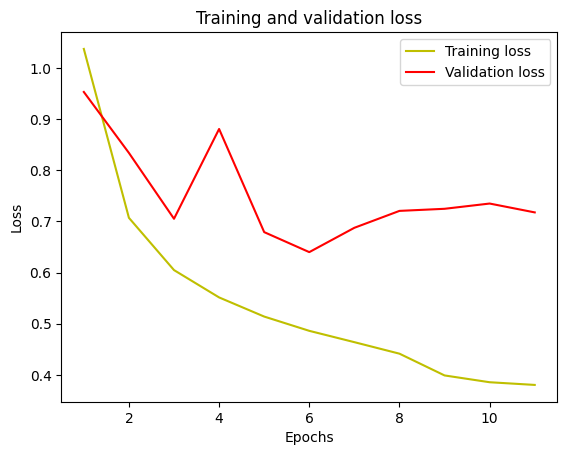

In [16]:
###
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

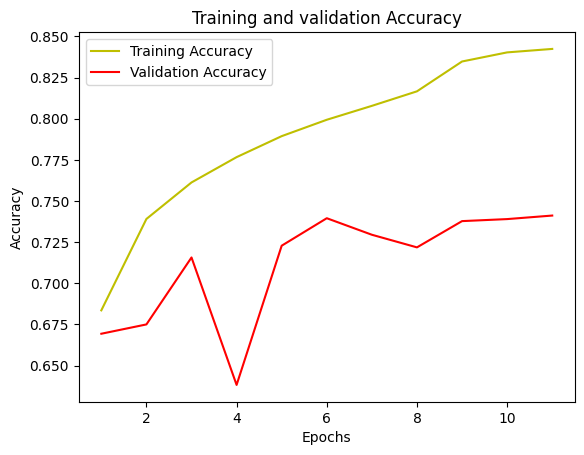

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Training and validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [18]:
X_test, y_test = sam_test_img, sam_test_mask

In [19]:
y_test_cat = to_categorical(y_test, num_classes=n_classes)

In [28]:
model.load_weights("model_usegnet_checkpoint.weights.h5")

In [20]:
# Predict and evaluate
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=-1)
y_true_classes = y_test

201/201 ━━━━━━━━━━━━━━━━━━━━ 84s 413ms/step


In [21]:
# Flatten the arrays
y_pred_flat = y_pred_classes.flatten()
y_true_flat = y_true_classes.flatten()

In [22]:
# Generate the classification report
from sklearn.metrics import classification_report
report = classification_report(y_true_flat, y_pred_flat, target_names=['Class 0', 
                                                                       'Class 1', 
                                                                       'Class 2', 
                                                                       'Class 3', 
                                                                       'Class 4', 
                                                                       'Class 5', 
                                                                       'Class 6', 
                                                                       'Class 8'])
print(report)

C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

     Class 0       0.00      0.00      0.00         8
     Class 1       0.47      0.11      0.18    293759
     Class 2       0.44      0.31      0.36    324962
     Class 3       0.45      0.42      0.44   1487533
     Class 4       0.57      0.59      0.58   2862958
     Class 5       0.64      0.77      0.70   7413470
     Class 6       0.93      0.84      0.88  12772966
     Class 8       0.51      0.54      0.53   1120184

    accuracy                           0.74  26275840
   macro avg       0.50      0.45      0.46  26275840
weighted avg       0.75      0.74      0.74  26275840



C:\Users\kholid\anaconda3\envs\tir\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [23]:
#IOU

n_classes = 8
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(y_test, y_pred_classes)
print("Mean IoU =", IOU_keras.result().numpy())

Mean IoU = 0.33639228
